# **Flight's ticket Price Prediction Model**

#  MLP Assignment-1 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


# Importing all the essential libraries for this project

In [2]:
# importing libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [3]:

df_train = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv")
df_train.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40000 non-null  int64  
 1   airline      35387 non-null  object 
 2   flight       40000 non-null  object 
 3   source       40000 non-null  object 
 4   departure    35208 non-null  object 
 5   stops        37681 non-null  object 
 6   arrival      40000 non-null  object 
 7   destination  40000 non-null  object 
 8   class        40000 non-null  object 
 9   duration     36987 non-null  float64
 10  days_left    35562 non-null  float64
 11  price        40000 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB


In [4]:
df_test = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10000 non-null  int64  
 1   airline      9452 non-null   object 
 2   flight       10000 non-null  object 
 3   source       10000 non-null  object 
 4   departure    9080 non-null   object 
 5   stops        9349 non-null   object 
 6   arrival      10000 non-null  object 
 7   destination  10000 non-null  object 
 8   class        10000 non-null  object 
 9   duration     9418 non-null   float64
 10  days_left    9304 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 859.5+ KB


In [5]:
df_train.drop(columns=["id"]).describe().T

,count,mean,std,min,25%,50%,75%,max
duration,36987.0,12.004088,7.108063,0.83,6.67,11.08,15.92,47.08
days_left,35562.0,26.197936,13.469232,1.00,15.00,26.00,38.00,49.00
price,40000.0,20801.490250,22729.148420,1105.00,4687.00,7353.00,42521.00,114704.00


In [6]:
print(df_train.isna().sum())
print("*"*40)
print(df_test.isna().sum())

id                0
airline        4613
flight            0
source            0
departure      4792
stops          2319
arrival           0
destination       0
class             0
duration       3013
days_left      4438
price             0
dtype: int64
****************************************
id               0
airline        548
flight           0
source           0
departure      920
stops          651
arrival          0
destination      0
class            0
duration       582
days_left      696
dtype: int64


In [7]:
for data in [df_train, df_test]:
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].fillna("Unknown")
        else:
            data[col] = data[col].fillna(data[col].median())

In [8]:
print(df_train.isna().sum())
print("*"*40)
print(df_test.isna().sum())

id             0
airline        0
flight         0
source         0
departure      0
stops          0
arrival        0
destination    0
class          0
duration       0
days_left      0
price          0
dtype: int64
****************************************
id             0
airline        0
flight         0
source         0
departure      0
stops          0
arrival        0
destination    0
class          0
duration       0
days_left      0
dtype: int64


In [9]:
df_train = df_train.drop_duplicates(subset=df_train.columns.difference(['id', 'price']))
df_train.shape

(39339, 12)

In [10]:
for data in [df_train, df_test]:
    for col in data.columns:
        if data[col].dtype != 'object':
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# **Data Visualization**

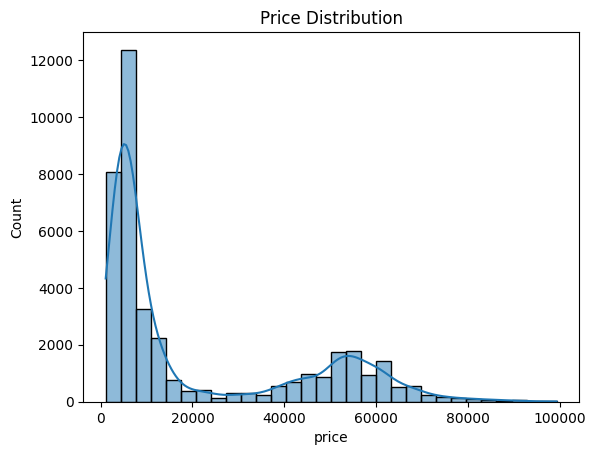

In [11]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    sns.histplot(df_train['price'], bins=30, kde=True)
    plt.title("Price Distribution")
    plt.show()

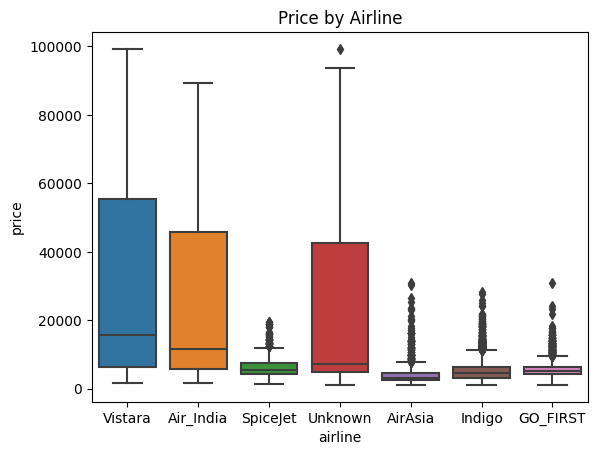

In [12]:
sns.boxplot(x='airline', y='price', data=df_train)
plt.xticks()
plt.title("Price by Airline")
plt.show()

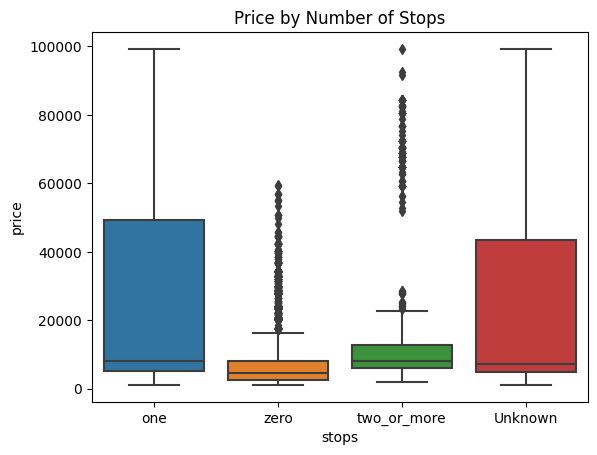

In [13]:
sns.boxplot(x='stops', y='price', data=df_train)
plt.title("Price by Number of Stops")
plt.show()

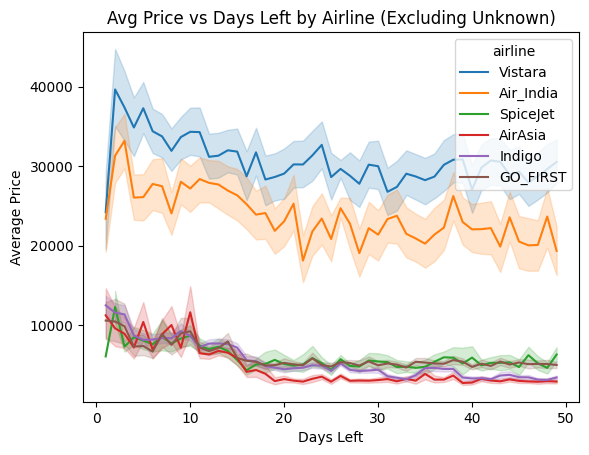

In [14]:
df_train_filtered = df_train[df_train['airline'] != 'Unknown']
warnings.simplefilter("ignore", category=FutureWarning)
# Line plot: Avg Price vs Days Left by Airline (excluding Unknown)
sns.lineplot(data=df_train_filtered, x='days_left', y='price', hue='airline', estimator='mean')
plt.title("Avg Price vs Days Left by Airline (Excluding Unknown)")
plt.xlabel("Days Left")
plt.ylabel("Average Price")
plt.show()

In [15]:
df_train.head()

,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price
0,0,Vistara,UK-930,Mumbai,Early_Morning,one,Night,Chennai,Business,11.08,40.0,64173
1,1,Air_India,AI-539,Chennai,Evening,one,Morning,Mumbai,Economy,16.08,26.0,4357
2,2,SpiceJet,SG-8107,Delhi,Early_Morning,zero,Morning,Chennai,Economy,2.92,25.0,3251
3,3,Unknown,0.00E+00,Hyderabad,Early_Morning,zero,Morning,Bangalore,Economy,1.50,22.0,1776
4,4,Air_India,AI-569,Chennai,Early_Morning,one,Morning,Bangalore,Economy,4.83,20.0,3584


In [16]:
# Separate features and target
df_train["airline_code"] = df_train["flight"].astype(str).str.extract(r"^([A-Z]{1,3})")
df_train['airline_code'] = df_train['airline_code'].fillna('unknown')
df_test["airline_code"] = df_test["flight"].astype(str).str.extract(r"^([A-Z]{1,3})")
df_test['airline_code'] = df_test['airline_code'].fillna('unknown')
df_train = df_train.drop("flight",axis=1)
df_test = df_test.drop("flight",axis=1)
X = df_train.drop(['price', 'id'], axis=1)
y = df_train['price']
test_ids = df_test['id']
df_test = df_test.drop('id', axis=1)

# Split train into train/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
num_cols = ['duration', 'days_left']
cat_cols = ['airline','airline_code','source','destination', 'departure', 'arrival', 'class', 'stops']

In [18]:
df_train.head()

,id,airline,source,departure,stops,arrival,destination,class,duration,days_left,price,airline_code
0,0,Vistara,Mumbai,Early_Morning,one,Night,Chennai,Business,11.08,40.0,64173,UK
1,1,Air_India,Chennai,Evening,one,Morning,Mumbai,Economy,16.08,26.0,4357,AI
2,2,SpiceJet,Delhi,Early_Morning,zero,Morning,Chennai,Economy,2.92,25.0,3251,SG
3,3,Unknown,Hyderabad,Early_Morning,zero,Morning,Bangalore,Economy,1.50,22.0,1776,unknown
4,4,Air_India,Chennai,Early_Morning,one,Morning,Bangalore,Economy,4.83,20.0,3584,AI


In [19]:
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[col])  # Fit only on training data
    
    X_train[col] = le.transform(X_train[col])
    X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    df_test[col] = df_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    encoders[col] = le


In [20]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

In [21]:
X_train.head()

,airline,source,departure,stops,arrival,destination,class,duration,days_left,airline_code
25883,6,2,2,1,1,3,1,0.319959,-0.089356,4
31551,5,3,1,1,2,4,1,-0.125933,-0.011326,1
34912,1,1,5,1,2,5,1,1.745328,0.378822,0
38570,6,3,5,1,4,2,0,-0.137823,-0.245415,4
11886,6,3,5,1,2,1,1,1.546163,-1.493888,4


# **Data Modelling**

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# === Step 1: Define Raw Models ===
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42, n_jobs=-1,n_estimators=1000,learning_rate=0.05),
    "LightGBM Regressor": LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1),
}

# === Step 2: Polynomial Regression Pipelines ===
poly2 = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

poly3 = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('regressor', LinearRegression())
])

# === Step 3: Fit and Evaluate ===
fitted_model = {}
model_metric = {}

# Original models
for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    model.fit(X_train, y_train)
    fitted_model[model_name] = model

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    model_metric[model_name] = {"R2": r2, "RMSE": rmse}

    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}\n")

# Polynomial Regression (deg=3)
print(f"--- Training Polynomial Regression (deg=3) ---")
poly3.fit(X_train, y_train)
y_pred_poly3 = poly3.predict(X_test)
rmse_poly3 = np.sqrt(mean_squared_error(y_test, y_pred_poly3))
r2_poly3 = r2_score(y_test, y_pred_poly3)
fitted_model["Polynomial Regression (deg=3)"] = poly3
model_metric["Polynomial Regression (deg=3)"] = {"R2": r2_poly3, "RMSE": rmse_poly3}
print(f"RMSE: {rmse_poly3:.2f}")
print(f"R2: {r2_poly3:.4f}\n")

--- Training Linear Regression ---
RMSE: 7095.87
R2: 0.9017

--- Training Ridge Regression ---
RMSE: 7095.83
R2: 0.9017

--- Training Lasso Regression ---
RMSE: 7095.84
R2: 0.9017

--- Training Decision Tree Regressor ---
RMSE: 4889.79
R2: 0.9533

--- Training Random Forest Regressor ---
RMSE: 3758.76
R2: 0.9724

--- Training Gradient Boosting Regressor ---
RMSE: 5121.20
R2: 0.9488

--- Training XGBoost Regressor ---
RMSE: 3882.37
R2: 0.9706

--- Training LightGBM Regressor ---
RMSE: 4239.50
R2: 0.9649

--- Training Polynomial Regression (deg=3) ---
RMSE: 5418.11
R2: 0.9427



In [23]:
params = {
    "Random Forest Regressor": {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    "XGBoost Regressor": {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "LightGBM Regressor": {
        'n_estimators': [50],
        'learning_rate': [0.05],
        'num_leaves': [20]
    }
}

In [24]:
for model_name, param in params.items():
    print(f"--- Tuning {model_name} ---")

    model = models[model_name]

    grid_search = GridSearchCV(model, param, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    tuned_model = grid_search.best_estimator_
    fitted_model[model_name] = tuned_model  # replacing our old fitted model with tuned one

    y_pred = tuned_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    model_metric[f"{model_name} (tuned)"] = {"R2": r2, "RMSE": rmse}

    print(f"{grid_search.best_params_}\n")

--- Tuning Random Forest Regressor ---
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

--- Tuning XGBoost Regressor ---
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

--- Tuning LightGBM Regressor ---
{'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 20}



In [25]:
performance_df_train = pd.DataFrame(model_metric).T.sort_values(by='RMSE')
performance_df_train

,R2,RMSE
Random Forest Regressor,0.972413,3758.755943
Random Forest Regressor (tuned),0.972413,3758.755943
XGBoost Regressor,0.970569,3882.369750
LightGBM Regressor,0.964905,4239.502627
XGBoost Regressor (tuned),0.959076,4578.039734
Decision Tree Regressor,0.953313,4889.787587
Gradient Boosting Regressor,0.948789,5121.204374
LightGBM Regressor (tuned),0.947437,5188.383117
Polynomial Regression (deg=3),0.942679,5418.113037
Ridge Regression,0.901685,7095.832640


In [26]:
final_model = fitted_model[performance_df_train.index[0]]
print(final_model)

RandomForestRegressor(n_jobs=-1, random_state=42)


In [27]:
full_x = pd.concat([X_train, X_test], axis=0)
full_y = pd.concat([y_train, y_test], axis=0)

In [28]:
final_model.fit(full_x, full_y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:
test_pred = final_model.predict(df_test)
test_pred = np.clip(test_pred, 0, None)

In [30]:
submission = pd.DataFrame({
    "id": range(df_test.shape[0]),
    "price": test_pred
})
submission.to_csv("submission.csv", index=False)
submission

,id,price
0,0,4678.26
1,1,13969.68
2,2,5025.36
3,3,59475.52
4,4,48415.99
...,...,...
9995,9995,4437.69
9996,9996,6096.09
9997,9997,82896.08
9998,9998,50371.91


In [31]:
from IPython.display import FileLink
FileLink("submission.csv")

/kaggle/working/submission.csv